In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import math
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.metrics import categorical_accuracy

#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger

In [3]:
# get all the directories of the data
train= '/content/drive/MyDrive/Colab Notebooks/primary_small/train'
valid= '/content/drive/MyDrive/Colab Notebooks/primary_small/valid'
test= '/content/drive/MyDrive/Colab Notebooks/primary_small/test'
classes = ["brightpixel", "narrowband","narrowbanddrd","noise","squarepulsednarrowband","squiggle","squigglesquarepulsednarrowband"]

In [4]:
train_batch_size = 32
img_dim = (80, 80)
classes = ['brightpixel', 'narrowband','narrowbanddrd', 'noise',  'squarepulsednarrowband', 'squiggle','squigglesquarepulsednarrowband']

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     zoom_range=0.2,
                                     fill_mode = 'nearest') 
valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory=train, classes=classes, target_size=img_dim, 
                                                    batch_size=train_batch_size, class_mode='categorical', interpolation='bicubic',
                                                   shuffle=True, seed=42)

val_generator = valid_datagen.flow_from_directory(directory=valid, classes = classes, target_size=img_dim, batch_size=64,
                                                 class_mode='categorical', shuffle=False, seed=42, interpolation='bicubic')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.0)

test_generator = test_datagen.flow_from_directory(directory=test, classes = classes, target_size=img_dim, batch_size=64,
                                                 class_mode='categorical', shuffle=False, seed=42, interpolation='bicubic')

Found 700 images belonging to 7 classes.


In [ ]:
#xtrain=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
#ytrain=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
xval=np.concatenate([val_generator.next()[0] for i in range(val_generator.__len__())])
yval=np.concatenate([val_generator.next()[1] for i in range(val_generator.__len__())])
#print(xtrain.shape)
#print(ytrain.shape)
print(xval.shape)
print(yval.shape)

(700, 80, 80, 3)
(700, 7)


In [ ]:
xtest=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
ytest=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])

In [ ]:
img = np.concatenate([xval,xtest])
lable = np.concatenate([yval,ytest])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img, lable, test_size=0.33, random_state=42)

In [5]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
np.save('X_train_QCNN', X_train)
np.save('X_test_QCNN', X_test)
np.save('y_train_QCNN', y_train)
np.save('y_test_QCNN', y_test)

In [6]:
X_train =np.load('X_train_QCNN.npy')
X_test =np.load('X_test_QCNN.npy')
y_train = np.load('y_train_QCNN.npy')
y_test = np.load('y_test_QCNN.npy')
print(y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [7]:
n_train = len(y_train)
n_test = len(y_test)

In [8]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.2 MB/s eta 0:00:00


In [9]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [10]:
n_layers = 2    # Number of random layers


SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)  

In [11]:
dev = qml.device("default.qubit", wires=4,shots = 500)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi=None):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [12]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((40,40, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0,80, 2):  #for j in range(0, 28, 2):
        for k in range(0,80, 2):  #for k in range(0, 28, 2):
          
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                phi=[
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(X_train):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(X_test):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)


Quantum pre-processing of train images:


In [ ]:
np.save('q_train_images_L2', q_train_images)
np.save('q_test_images_L2', q_test_images)
#ValueError: 'rgb' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocea...


In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(X_train[k, :, :, :], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap='hot')

plt.tight_layout()
plt.show()
plt.savefig('QCNN_2_500.png', dpi =300)

In [ ]:
from tensorflow.keras.layers.experimental import RandomFourierFeatures 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import AveragePooling2D 
from tensorflow.python.keras import regularizers


In [ ]:
ytrain1 = y_train[:,0]
yval1 = y_test[:,0]
print(ytrain1.shape)
print(yval1.shape)
print(q_train_images.shape)
print(q_test_images.shape)

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.SeparableConv2D(512, (3,3), strides=(1, 1), activation="elu", kernel_regularizer=regularizers.l2(l=0.01)),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l=0.01)),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(7, activation="softmax")
    ])

    model.compile(
        optimizer='sgd',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
#def MyModel():
   # """Initializes and returns a custom Keras model
   # which is ready to be trained."""
   # model = keras.models.Sequential([
    #    keras.layers.SeparableConv2D(128, (3,3), strides=(1, 1), activation="elu", kernel_regularizer=regularizers.l2(l=0.01)),  
    #    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),                                                       
        #keras.layers.Dense(512, activation="elu"),  
    #    keras.layers.Dense(512, activation="elu", kernel_regularizer=regularizers.l2(l=0.01)), 
                                    
     #   keras.layers.Flatten(),
        
     #   keras.layers.Dense(7, activation="softmax")
  #  ])

    #model.compile(
     #   optimizer='nadam',
      #  loss="sparse_categorical_crossentropy",
      #  metrics=["accuracy"],
   # )
    
    #return model

In [ ]:
def MyModel1():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.SeparableConv2D(512, (3,3), strides=(1, 1), activation="elu", kernel_regularizer=regularizers.l2(l=0.01)),  
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),                                                       
        #keras.layers.Dense(512, activation="elu"),  
        keras.layers.Dense(128, activation="elu", kernel_regularizer=regularizers.l2(l=0.01)), 
                                    
        keras.layers.Flatten(),
        
        keras.layers.Dense(7, activation="softmax")
    ])

    model.compile(
        optimizer='sgd',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    ytrain1,
    validation_data=(q_test_images, yval1),
    batch_size=4,
    epochs=100,
    verbose=2,
)
print(q_history.history.keys())
#  "Accuracy"
plt.plot(q_history.history['accuracy'])
plt.plot(q_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(q_history.history['loss'])
plt.plot(q_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("Training Score: ", q_model.evaluate(q_train_images, ytrain1))

In [ ]:
print("Val Score: ", q_model.evaluate(q_test_images, yval1))

15/15 [==============================] - 0s 8ms/step - loss: 0.3373 - accuracy: 0.8939
Val Score:  [0.3373265266418457, 0.8939393758773804]


In [ ]:
predictions = q_model.predict(q_test_images).round()
# Classification Report
from sklearn.metrics import classification_report, accuracy_score
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']
#print(predictions)
#print(yval1)

15/15 [==============================] - 0s 4ms/step


In [ ]:
#y_test_arg=np.argmax(yval1)
Y_pred = np.argmax(q_model.predict(q_test_images),axis=1)
print('Confusion Matrix')
print(confusion_matrix(yval1, Y_pred))
print('Classification Matrix')
print(classification_report(yval1, Y_pred))
print('Accuracy')
print(accuracy_score(yval1, Y_pred))

15/15 [==============================] - 0s 5ms/step
Confusion Matrix
[[403   0]
 [ 49  10]]
Classification Matrix
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       403
         1.0       1.00      0.17      0.29        59

    accuracy                           0.89       462
   macro avg       0.95      0.58      0.62       462
weighted avg       0.91      0.89      0.86       462

Accuracy
0.8939393939393939


In [ ]:
print(ytrain1.shape)
print(yval1.shape)
print(q_train_images.shape)
print(q_test_images.shape)
print(ytrain1)
from keras.utils import to_categorical

# One-hot encode the categorical labels
train_labels = to_categorical(ytrain1)
test_labels = to_categorical(yval1)

(938,)
(462,)
(938, 40, 40, 4)
(462, 40, 40, 4)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.

In [ ]:
import itertools
def plot_confusion_matrix(cm, class_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

30/30 [==============================] - 0s 4ms/step
Normalized confusion matrix


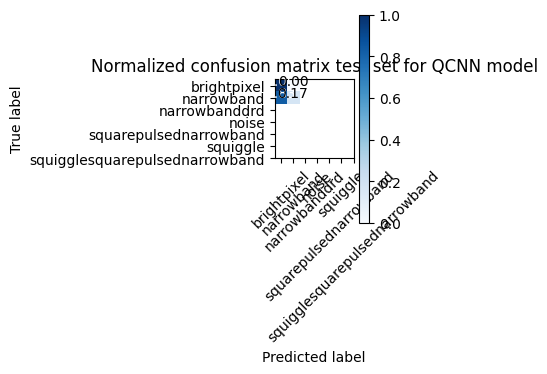

In [ ]:
y_pred_testQ = q_model.predict(q_test_images)
y_pred_trainQ = q_model.predict(q_train_images)
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(y_pred_testQ, axis=1))
np.set_printoptions(precision=7)

# Plot non-normalized confusion matrix
plt.figure(figsize=(4, 4))

plot_confusion_matrix(cnf_matrix, class_names=['brightpixel', 'narrowband','narrowbanddrd', 'noise',  'squarepulsednarrowband', 'squiggle','squigglesquarepulsednarrowband'],normalize=True,
                      title='Normalized confusion matrix test set for QCNN model')

In [ ]:
classes1= test_labels
predict = y_pred_testQ
from sklearn.preprocessing import label_binarize
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#predictions = pp[:, 1]
#fpr, tpr, threshold = metrics.roc_curve(valid_batches.labels, predictions)
y = label_binarize(classes1, classes =['brightpixel', 'narrowband','narrowbanddrd', 'noise',  'squarepulsednarrowband', 'squiggle','squigglesquarepulsednarrowband'])
n_classes = 7
#predict1=np.argmax(predict, axis=0)
predict2=np.argmax(classes1, axis=1)
#y_pred = np.argmax(predict, axis=1)
#z=pd.DataFrame(data=classes1,)a
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(classes1[:,i], predict[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(classes1.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average:ROC(area= {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average:ROC(area= {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['green', 'darkorange', 'red','darkviolet'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC:Class{0}(area= {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic:Four-class')
plt.legend(loc="lower right")
#plt.show()
plt.savefig('ModelDenseROCFullDNN.jpg', dpi=200)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-67-fdd6b2af9591>", line 19, in <cell line: 19>
    y = label_binarize(classes1, classes =['brightpixel', 'narrowband','narrowbanddrd', 'noise',  'squarepulsednarrowband', 'squiggle','squigglesquarepulsednarrowband'])
  File "/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py", line 541, in label_binarize
    raise ValueError(
ValueError: classes ['brightpixel' 'narrowband' 'narrowbanddrd' 'noise'
 'squarepulsednarrowband' 'squiggle' 'squigglesquarepulsednarrowband'] mismatch with the labels [0 1] found in the data

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_t

In [ ]:
q_model4 = MyModel()

In [ ]:
q_model3 = MyModel()

In [ ]:
img = np.concatenate([q_train_images, q_test_images])
lab = np.concatenate([ytrain1, yval1])

In [ ]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=128):
    model = None
    results = q_model3.fit(t_x, t_y, epochs=10, batch_size=64, 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", q_model3.evaluate(val_x, val_y))
    return results

In [ ]:
from sklearn.model_selection import train_test_split
n_folds=3
epochs=50
batch_size=8

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(img, lab, test_size=0.1)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10
18/18 [==============================] - 2s 53ms/step - loss: 3.2011 - accuracy: 0.8439 - val_loss: 3.0064 - val_accuracy: 0.8413
Epoch 2/10
18/18 [==============================] - 1s 30ms/step - loss: 2.9946 - accuracy: 0.8563 - val_loss: 2.9796 - val_accuracy: 0.8413
Epoch 3/10
18/18 [==============================] - 1s 30ms/step - loss: 2.9522 - accuracy: 0.8554 - val_loss: 2.9553 - val_accuracy: 0.8413
Epoch 4/10
18/18 [==============================] - 1s 30ms/step - loss: 2.9469 - accuracy: 0.8563 - val_loss: 2.9299 - val_accuracy: 0.8413
Epoch 5/10
18/18 [==============================] - 1s 30ms/step - loss: 2.9093 - accuracy: 0.8563 - val_loss: 2.9102 - val_accuracy: 0.8413
Epoch 6/10
18/18 [==============================] - 1s 30ms/step - loss: 2.8930 - accuracy: 0.8563 - val_loss: 2.8945 - val_accuracy: 0.8413
Epoch 7/10
18/18 [==============================] - 1s 30ms/step - loss: 2.8710 - accuracy: 0.8563 - val_loss: 2.8732 - val_accuracy:

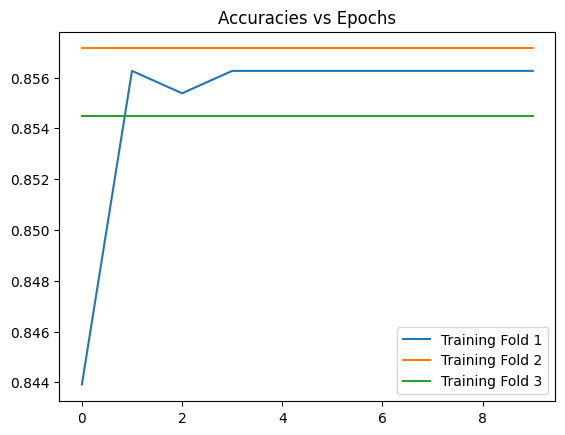

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

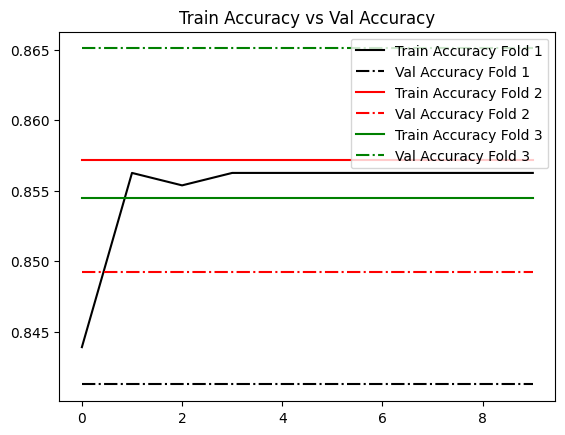

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()
plt.savefig('FOLDCOMP_L2_500.png', dpi =300)

In [ ]:
q_model3